In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import requests
import os
from IPython.display import display

In [ ]:
raw = pd.read_json('./trump_tweets.json')
raw.head(5)

,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged
0,98454970654916600,Republicans and Democrats have both created ou...,f,f,TweetDeck,49,255,2011-08-02 18:07:48,f
1,1234653427789070300,I was thrilled to be back in the Great city of...,f,f,Twitter for iPhone,73748,17404,2020-03-03 01:34:50,f
2,1218010753434820600,RT @CBS_Herridge: READ: Letter to surveillance...,t,f,Twitter for iPhone,0,7396,2020-01-17 03:22:47,f
3,1304875170860015600,The Unsolicited Mail In Ballot Scam is a major...,f,f,Twitter for iPhone,80527,23502,2020-09-12 20:10:58,f
4,1218159531554898000,RT @MZHemingway: Very friendly telling of even...,t,f,Twitter for iPhone,0,9081,2020-01-17 13:13:59,f


In [ ]:
range_tweet = raw[(raw['date'] >= "2017-01-01") & (raw['date'] <= "2021-01-01") & (raw['isRetweet'] == 'f')]
range_tweet = range_tweet.sort_values(by="date")
range_tweet = range_tweet[['text', 'date']]
range_tweet['date'] = range_tweet['date'].dt.strftime('%Y-%m-%d')
range_tweet.head(5)

,text,date
45878,"TO ALL AMERICANS-#HappyNewYear &amp, many bles...",2017-01-01
45872,"Well, the New Year begins. We will, together, ...",2017-01-02
45871,"Chicago murder rate is record setting - 4,331 ...",2017-01-02
45870,"@CNN just released a book called """"Unprecedent...",2017-01-02
45869,Various media outlets and pundits say that I t...,2017-01-02


In [ ]:
raw_djia = pd.read_csv('./DJIA.csv')
raw_djia = raw_djia[['Date', 'Open', 'Price']]
raw_djia['Date'] = pd.to_datetime(raw_djia['Date'])
raw_djia = raw_djia.sort_values(by="Date")
raw_djia['Date'] = raw_djia['Date'].dt.strftime('%Y-%m-%d')
raw_djia = raw_djia.set_index(raw_djia['Date']).drop('Date', axis=1)
raw_djia.head(5)

,Open,Price
Date,,
2017-01-03,"19,872.86","19,881.76"
2017-01-04,"19,890.94","19,942.16"
2017-01-05,"19,924.56","19,899.29"
2017-01-06,"19,906.96","19,963.80"
2017-01-09,"19,931.41","19,887.38"


In [ ]:
temp = {}
dates = raw_djia.index.to_numpy()
for index, row in range_tweet.iterrows():
  if row['date'] in dates:
    if row['date'] in temp:
      temp[row['date']][0].append([row['text']])
    else:
      temp[row['date']] = [[[row['text']]]]

tweets = pd.DataFrame.from_dict(temp, orient='index')

djia_dates = temp.keys()
remove_date = []
for i in dates:
  if i not in djia_dates:
    remove_date.append(i)

djia = raw_djia.drop(index=remove_date)

# assert all dates match between tweets and djia
date1 = tweets.index.to_numpy()
date2 = djia.index.to_numpy()
assert(len(date1) == len(date2))
for i in range(len(date1)):
  assert(date1[i] == date2[i])

In [ ]:
display(tweets.head(5))
display(djia.head(5))

,0
2017-01-03,[[General Motors is sending Mexican made model...
2017-01-04,"[[The """"Intelligence"""" briefing on so-called ""..."
2017-01-05,"[[The Democrats, lead by head clown Chuck Schu..."
2017-01-06,"[[How did NBC get """"an exclusive look into the..."
2017-01-09,[[Dishonest media says Mexico won't be paying ...


,Open,Price
Date,,
2017-01-03,"19,872.86","19,881.76"
2017-01-04,"19,890.94","19,942.16"
2017-01-05,"19,924.56","19,899.29"
2017-01-06,"19,906.96","19,963.80"
2017-01-09,"19,931.41","19,887.38"


In [ ]:
!pip install mxnet
!pip install gluonnlp
!pip install mxnet-cu101
import mxnet as mx
from mxnet import gluon
from embedding import BertEmbedding

# Get GPU
ctx = mx.gpu()

# Define a model in GPU for faster training
bert_embedding = BertEmbedding(model='bert_12_768_12', dataset_name='book_corpus_wiki_en_cased', ctx=ctx)

     |████████████████████████████████| 46.9 MB 82 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 344 kB 9.2 MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595734 sha256=824e79b10eab5b9ac7a45d8c3468b0ea9b9bc853f0e9728d64fe6badafa25238
  Stored in directory: /root/.cache/pip/wheels/be/b4/06/7f3fdfaf707e6b5e98b79c041e023acffbe395d78a527eae00
Successfully built gluonnlp
     |████████████████████████████████| 356.7 MB 31 kB/s 
Vocab file is not found. Downloading.


In [ ]:
def embedding(x):
  res = []
  for i in x:
    res.append(np.array(bert_embedding(i)[0][1]).sum(axis=0))
  return np.array(res)

tweets_embedding = tweets.iloc[:, 0].apply(embedding)
tweets_embedding = tweets_embedding.to_frame()
tweets_embedding.head(5)

,0
2017-01-03,"[[4.3071494, -3.3733706, -0.115477756, 2.08822..."
2017-01-04,"[[2.7260141, 9.427972, -2.5439198, 0.9613182, ..."
2017-01-05,"[[0.7244632, 0.36972582, 3.083221, 1.0836651, ..."
2017-01-06,"[[4.3682914, 0.25370705, -1.8765447, -5.630945..."
2017-01-09,"[[-0.0197815, 0.20498717, -1.1499792, 1.968534..."


In [ ]:
combined_embedding = tweets_embedding[0].map(lambda x: np.concatenate((np.min(x, axis=0), np.max(x, axis=0), np.sum(x, axis=0), np.mean(x, axis=0)))).to_frame()
combined_embedding.head(5)

,0
2017-01-03,"[-2.278419, -3.3733706, -4.809018, -7.9781666,..."
2017-01-04,"[-1.1561407, -1.166659, -5.6205516, -3.1361213..."
2017-01-05,"[-0.29112166, -4.3002315, -1.8166572, -8.41733..."
2017-01-06,"[-0.66774607, -1.5986894, -6.411251, -5.630945..."
2017-01-09,"[-2.3248293, -1.1693738, -7.619992, -4.6650395..."


In [ ]:
from google.colab import files
combined_embedding.to_json('combined_embedding_djia.json')
files.download('./combined_embedding_djia.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def transform_data(tbl):
    
    tbl = pd.DataFrame(tbl.iloc[:, 0].tolist())
    tbl = tbl.set_index(djia.index)

    return tbl


def split_test(embedding, test_size):
    
    embedding_test = embedding.iloc[-test_size:, :]
    embedding = embedding.iloc[:-test_size, :]
    
    return embedding_test, embedding

In [ ]:
combined_embedding = transform_data(combined_embedding)

In [ ]:
# djia = djia.applymap(lambda x: float(x.replace(',', '')))
open_price = djia[['Open']]
adj_close_price = djia[['Price']]
display(open_price)
display(adj_close_price)

,Open
Date,
2017-01-03,19872.86
2017-01-04,19890.94
2017-01-05,19924.56
2017-01-06,19906.96
2017-01-09,19931.41
...,...
2020-12-24,30155.92
2020-12-28,30283.23
2020-12-29,30492.07


,Price
Date,
2017-01-03,19881.76
2017-01-04,19942.16
2017-01-05,19899.29
2017-01-06,19963.80
2017-01-09,19887.38
...,...
2020-12-24,30199.87
2020-12-28,30403.97
2020-12-29,30335.67


In [ ]:
test_size = 100

combined_embedding_test, combined_embedding_train = split_test(combined_embedding, test_size)

open_price_test, open_price_train = split_test(open_price, test_size)
adj_close_price_test, adj_close_price_train = split_test(adj_close_price, test_size)

print(combined_embedding_train.shape, open_price_train.shape, adj_close_price_train.shape)
print(combined_embedding_test.shape, adj_close_price_test.shape, adj_close_price_test.shape)

(901, 3072) (901, 1) (901, 1)
(100, 3072) (100, 1) (100, 1)


In [ ]:
# Model definition

# Hyperparameters
dropout_rate = 0.5
learning_rate = 0.001

# inputs = tf.keras.Input(shape=(769,))
# layer1 = tf.keras.layers.Dense(1000)(inputs)
# layer1 = tf.keras.layers.Dropout(dropout_rate)(layer1)
# layer1 = tf.keras.layers.BatchNormalization(axis=1)(layer1)
# layer2 = tf.keras.layers.Dense(100)(layer1)
# layer2 = tf.keras.layers.Dropout(dropout_rate)(layer2)
# layer2 = tf.keras.layers.BatchNormalization(axis=1)(layer2)
# layer3 = tf.keras.layers.Dense(10)(layer2)
# layer3 = tf.keras.layers.Dropout(dropout_rate)(layer3)
# layer3 = tf.keras.layers.BatchNormalization(axis=1)(layer3)
# layer4 = tf.keras.layers.Dense(1)(layer3)

open_price_inputs = tf.keras.Input(shape=(1,), name='open_price')
combined_inputs = tf.keras.Input(shape=(3072,), name='combined')
x = tf.keras.layers.Dense(1000)(combined_inputs)
x = tf.keras.layers.Dropout(dropout_rate)(x)
x = tf.keras.layers.BatchNormalization(axis=1)(x)
x = tf.keras.layers.Dense(500)(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)
x = tf.keras.layers.BatchNormalization(axis=1)(x)
x = tf.keras.layers.Dense(1)(x)
x = tf.keras.layers.Multiply()([x, open_price_inputs])
x = tf.keras.layers.Dense(100)(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)
x = tf.keras.layers.BatchNormalization(axis=1)(x)
x = tf.keras.layers.Dense(1)(x)

combined_embedding_model = tf.keras.Model(inputs=[combined_inputs, open_price_inputs], outputs=x, name="combined_embedding_model")

# display(max_embedding_model.summary())
display(combined_embedding_model.summary())

Model: "combined_embedding_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
combined (InputLayer)           [(None, 3072)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 1000)         3073000     combined[0][0]                   
__________________________________________________________________________________________________
dropout (Dropout)               (None, 1000)         0           dense[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 1000)         4000        dropout[0][0]                    
___________________________________________________________________________

None

In [ ]:
def RootMeanSquaredError(y_actual, y_predict):
  mse = tf.keras.losses.MeanSquaredError()
  return tf.sqrt(mse(y_actual, y_predict))

# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [ ]:
combined_embedding_model.compile(
    loss=RootMeanSquaredError,
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
combined_embedding_history = combined_embedding_model.fit({'combined': combined_embedding_train, 'open_price': open_price_train}, adj_close_price_train, batch_size=16, epochs=300, validation_split=0.1, verbose=1)

Epoch 1/300
51/51 [==============================] - 1s 9ms/step - loss: 24677.6348 - root_mean_squared_error: 24684.7637 - val_loss: 25172.3770 - val_root_mean_squared_error: 25208.2188
Epoch 2/300
51/51 [==============================] - 0s 5ms/step - loss: 24677.3457 - root_mean_squared_error: 24683.6289 - val_loss: 25180.1562 - val_root_mean_squared_error: 25215.9727
Epoch 3/300
51/51 [==============================] - 0s 5ms/step - loss: 24675.7949 - root_mean_squared_error: 24681.3633 - val_loss: 25181.8652 - val_root_mean_squared_error: 25217.6934
Epoch 4/300
51/51 [==============================] - 0s 5ms/step - loss: 24670.6074 - root_mean_squared_error: 24677.5781 - val_loss: 25180.0527 - val_root_mean_squared_error: 25215.8828
Epoch 5/300
51/51 [==============================] - 0s 5ms/step - loss: 24665.2793 - root_mean_squared_error: 24672.2598 - val_loss: 25174.6641 - val_root_mean_squared_error: 25210.4668
Epoch 6/300
51/51 [==============================] - 0s 4ms/step 

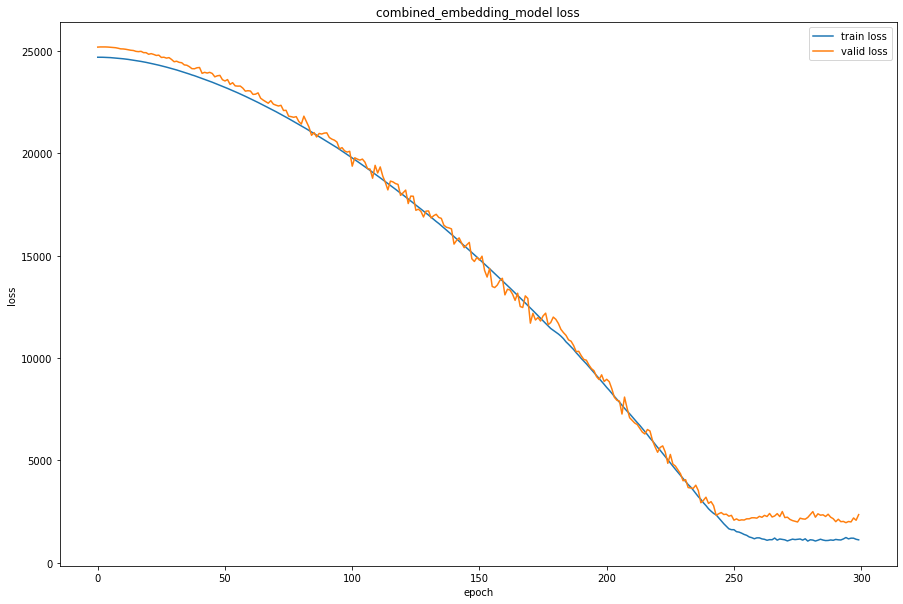

In [ ]:
# summarize history for loss
plt.figure(figsize=(15,10))
plt.plot(combined_embedding_history.history['loss'])
plt.plot(combined_embedding_history.history['val_loss'])
plt.title('combined_embedding_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'valid loss'], loc='upper right')
plt.show()

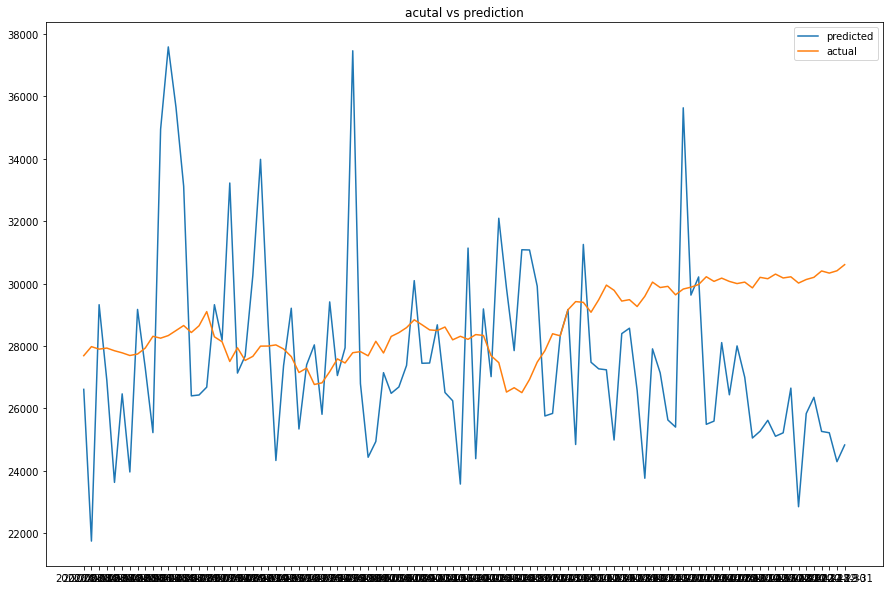

In [ ]:
predicted_close_price = combined_embedding_model.predict([combined_embedding_test, open_price_test])

# plot acutal vs prediction
plt.figure(figsize=(15,10))
plt.plot(predicted_close_price)
plt.plot(adj_close_price_test)
plt.title('acutal vs prediction')
# plt.ylabel('predicted_close_price')
# plt.xlabel('epoch')
plt.legend(['predicted', 'actual'], loc='upper right')
plt.show()

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
combined_embedding_model.save("./combined_embedding_model")

INFO:tensorflow:Assets written to: ./combined_embedding_model/assets


INFO:tensorflow:Assets written to: ./combined_embedding_model/assets
